In [1]:
import os
os.environ["CALITP_BQ_MAX_BYTES"] = str(100_000_000_000)

from calitp.tables import tbl
from calitp import query_sql
import calitp.magics

import shared_utils
import branca
from utils import *

from siuba import *
import pandas as pd
import geopandas as gpd
import shapely

import datetime as dt
import time
from zoneinfo import ZoneInfo

import rt_analysis as rt
import importlib

/Users/edasmalchi/miniconda3/envs/calitp/lib/python3.10/site-packages/google/cloud/bigquery/client.py:535: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  warnings.warn(


### Get and transform test data (Long Beach Transit, 170)

In [2]:
lbt_itp_id = 170

In [3]:
# %%sql -o lbt_positions

# # get all vehicle positions on selected dates, for the feed with itp id 170, and url number 0
# SELECT *
# FROM `cal-itp-data-infra.gtfs_rt.vehicle_positions`
# WHERE _FILE_NAME="gs://gtfs-data/rt-processed/vehicle_positions/vp_2021-12-01_170_0.parquet"
#     OR _FILE_NAME="gs://gtfs-data/rt-processed/vehicle_positions/vp_2021-11-30_170_0.parquet"
#     # OR _FILE_NAME="gs://gtfs-data/rt-processed/vehicle_positions/vp_2021-12-03_170_0.parquet"
#     # OR _FILE_NAME="gs://gtfs-data/rt-processed/vehicle_positions/vp_2021-12-04_170_0.parquet"
#     # OR _FILE_NAME="gs://gtfs-data/rt-processed/vehicle_positions/vp_2021-12-05_170_0.parquet"
#     # OR _FILE_NAME="gs://gtfs-data/rt-processed/vehicle_positions/vp_2021-12-06_170_0.parquet"
#     # OR _FILE_NAME="gs://gtfs-data/rt-processed/vehicle_positions/vp_2021-12-07_170_0.parquet"
# ORDER BY header_timestamp

#### Reformat timestamps

In [4]:
# ## set system time
# os.environ['TZ'] = 'America/Los_Angeles'
# time.tzset()
# time.tzname

In [5]:
# lbt_positions.vehicle_timestamp = lbt_positions.vehicle_timestamp.apply(convert_ts)
# lbt_positions.header_timestamp = lbt_positions.header_timestamp.apply(convert_ts)

In [6]:
# lbt_positions.to_parquet(f'{GCS_FILE_PATH}lbt_positions.parquet')

In [7]:
lbt_positions = pd.read_parquet(f'{GCS_FILE_PATH}lbt_positions.parquet')

In [8]:
pch_routes = ('171', '172', '173', '174', '175')

In [9]:
# min_date, max_date = ('2021-11-01', '2021-11-30')

# lbt_trips = (tbl.views.gtfs_schedule_fact_daily_trips()
#     >> filter(_.calitp_extracted_at <= min_date, _.calitp_deleted_at > max_date)
#     >> filter(_.calitp_itp_id == lbt_itp_id)
#     >> filter(_.service_date == max_date)
#     >> filter(_.is_in_service == True)
#     >> select(_.trip_key, _.service_date)
#     >> inner_join(_, tbl.views.gtfs_schedule_dim_trips(), on = 'trip_key')
#     >> select(_.calitp_itp_id, _.calitp_url_number, _.service_date,
#               _.trip_key, _.trip_id, _.route_id, _.direction_id,
#               _.shape_id, _.calitp_extracted_at, _.calitp_deleted_at)
#     # >> filter(_.route_id.isin(pch_routes))

#     >> collect()
#     )

In [10]:
# lbt_trips.to_parquet(f'{GCS_FILE_PATH}lbt_trips.parquet')

In [11]:
lbt_trips = pd.read_parquet(f'{GCS_FILE_PATH}lbt_trips.parquet')

In [12]:
# stop_times = (tbl.gtfs_schedule.stop_times()
#      >> filter(_.calitp_itp_id == 170)
#      # >> filter(_.trip_id == '9288623')
#      >> mutate(stop_sequence = _.stop_sequence.astype(int)) ## in SQL!
#      >> arrange(_.stop_sequence)
#      >> collect()
#     )

In [13]:
# stop_times.to_parquet(f'{GCS_FILE_PATH}lbt_st.parquet')

In [14]:
stop_times = pd.read_parquet(f'{GCS_FILE_PATH}lbt_st.parquet')

In [15]:
# stops = (tbl.gtfs_schedule.stops()
#      >> filter(_.calitp_itp_id == 170)
#      # >> filter(_.trip_id == '9288623')
#      # >> mutate(stop_sequence = _.stop_sequence.astype(int)) ## in SQL!
#      # >> arrange(_.stop_sequence)
#      >> select(_.calitp_itp_id, _.calitp_url_number, _.stop_id,
#               _.stop_lat, _.stop_lon, _.stop_name)
#      >> collect()
#     )

# stops = gpd.GeoDataFrame(stops, geometry=gpd.points_from_xy(stops.stop_lon, stops.stop_lat),
#                         crs='EPSG:4326').to_crs(shared_utils.geography_utils.CA_NAD83Albers)

In [16]:
# shared_utils.utils.geoparquet_gcs_export(stops, GCS_FILE_PATH, 'lbt_stops')

In [17]:
stops = gpd.read_parquet(f'{GCS_FILE_PATH}lbt_stops.parquet')

In [18]:
trips_positions_joined = (lbt_trips
                        # >> filter(_.route_id.isin(pch_routes))
                        >> inner_join(_, (lbt_positions >> rename(trip_id = 'vehicle_trip_id')),
                                      on= ['trip_id', 'calitp_itp_id', 'calitp_url_number'])
                       )

In [19]:
trips_positions_joined.vehicle_timestamp.max()

Timestamp('2021-12-01 11:15:59')

In [20]:
trips_positions_joined.vehicle_timestamp.min()

Timestamp('2021-11-29 15:57:13')

In [21]:
trips_positions_joined = gpd.GeoDataFrame(trips_positions_joined,
                                geometry=gpd.points_from_xy(trips_positions_joined.vehicle_position_longitude,
                                                            trips_positions_joined.vehicle_position_latitude),
                                crs=shared_utils.geography_utils.WGS84).to_crs(shared_utils.geography_utils.CA_NAD83Albers)

In [22]:
# lbt_routelines = shared_utils.geography_utils.make_routes_shapefile(['170'], ## LBT
#                                 shared_utils.geography_utils.CA_NAD83Albers)

In [23]:
# shared_utils.utils.geoparquet_gcs_export(lbt_routelines, GCS_FILE_PATH, 'lbt_routelines')

In [24]:
lbt_routelines = gpd.read_parquet(f'{GCS_FILE_PATH}lbt_routelines.parquet')

In [25]:
trips_positions_joined = trips_positions_joined >> filter(_.vehicle_timestamp.apply(lambda x: x.day == 30))

In [26]:
trips_positions_joined.head(3)

,calitp_itp_id,calitp_url_number,service_date,trip_key,trip_id,route_id,direction_id,shape_id,calitp_extracted_at,calitp_deleted_at,entity_id,vehicle_id,vehicle_timestamp,vehicle_position_latitude,vehicle_position_longitude,header_timestamp,geometry
285,170,0,2021-11-30,7580361081022204604,9296678,41,0,410007,2021-09-16,2099-01-01,2706,None,2021-11-30 17:50:18,33.78208,-118.11597,2021-11-30 17:50:38,POINT (174524.587 -468602.041)
286,170,0,2021-11-30,7580361081022204604,9296678,41,0,410007,2021-09-16,2099-01-01,2706,None,2021-11-30 17:50:18,33.78208,-118.11597,2021-11-30 17:50:38,POINT (174524.587 -468602.041)
287,170,0,2021-11-30,7580361081022204604,9296678,41,0,410007,2021-09-16,2099-01-01,2706,None,2021-11-30 17:50:18,33.78208,-118.11597,2021-11-30 17:51:08,POINT (174524.587 -468602.041)


In [27]:
stop_times.head(3)

,calitp_itp_id,calitp_url_number,trip_id,stop_id,stop_sequence,arrival_time,departure_time,stop_headsign,pickup_type,drop_off_type,continuous_pickup,continuous_drop_off,shape_dist_traveled,timepoint,calitp_extracted_at
0,170,0,9285982,0666,1,10:41:00,10:41:00,None,0,0,None,None,0.0,1,2021-12-17
1,170,0,9288986,4003,1,17:05:00,17:05:00,None,0,1,None,None,0.0,1,2021-12-17
2,170,0,9286129,4012,1,14:20:00,14:20:00,None,0,1,None,None,0.0,1,2021-12-17


## Vehicle Positions Trip class

#### Examples

In [28]:
example_trip = (trips_positions_joined
 >> filter(_.trip_key == 1553149201202261125)
)

In [29]:
example_trip.head(3)

,calitp_itp_id,calitp_url_number,service_date,trip_key,trip_id,route_id,direction_id,shape_id,calitp_extracted_at,calitp_deleted_at,entity_id,vehicle_id,vehicle_timestamp,vehicle_position_latitude,vehicle_position_longitude,header_timestamp,geometry
327364,170,0,2021-11-30,1553149201202261125,9288623,175,0,1750012,2021-09-16,2099-01-01,2901,None,2021-11-30 17:02:12,33.78207,-118.11569,2021-11-30 17:02:37,POINT (174550.543 -468602.634)
327365,170,0,2021-11-30,1553149201202261125,9288623,175,0,1750012,2021-09-16,2099-01-01,2901,None,2021-11-30 17:02:12,33.78207,-118.11569,2021-11-30 17:02:37,POINT (174550.543 -468602.634)
327366,170,0,2021-11-30,1553149201202261125,9288623,175,0,1750012,2021-09-16,2099-01-01,2901,None,2021-11-30 17:02:12,33.78207,-118.11569,2021-11-30 17:03:07,POINT (174550.543 -468602.634)


In [30]:
example_vp_trip = rt.VehiclePositionsTrip(example_trip, lbt_routelines)

sc_called
(59, 4)


In [31]:
example_vp_trip.vehicle_positions.head(3)

,vehicle_timestamp,header_timestamp,geometry,shape_meters,last_time,last_loc,secs_from_last,meters_from_last,progressed,speed_from_last
0,2021-11-30 17:02:12,2021-11-30 17:02:37,POINT (174550.543 -468602.634),74.859821,NaT,NaN,NaN,NaN,False,NaN
1,2021-11-30 17:03:13,2021-11-30 17:03:37,POINT (174199.449 -468606.611),426.426159,2021-11-30 17:02:12,74.859821,61.0,351.566339,True,5.763383
2,2021-11-30 17:04:13,2021-11-30 17:04:37,POINT (173950.226 -468607.891),676.381408,2021-11-30 17:03:13,426.426159,60.0,249.955248,True,4.165921


In [32]:
example_vp_trip.time_at_position(550) ## interpolate time at 550 meters from start of route (shape_meters in df^)

Timestamp('2021-11-30 17:03:42.663032')

In [33]:
# example_vp_trip.detailed_speed_map()

In [34]:
importlib.reload(rt)

<module 'rt_analysis2' from '/Users/edasmalchi/calitp/data-analyses/rt_delay/rt_analysis2.py'>

In [35]:
# example_vp_trip2 = rt.VehiclePositionsInterpolator(example_trip, lbt_routelines)

In [36]:
# example_vp_trip2.time_at_position(550) ## interpolate time at 550 meters from start of route (shape_meters in df^)

In [37]:
# example_vp_trip2.detailed_speed_map()

### rt

one_trip = lbt_trips >> filter(_.trip_key == 3082123411846948636) >> select(-_.calitp_deleted_at,
                                                                           -_.calitp_extracted_at)

trip_st_gdf = test_analysis.st_geo >> inner_join(_, one_trip,
                                           on = ['calitp_itp_id', 'calitp_url_number', 'trip_id'])## General RT Analysis class

In [38]:
example_trips = (trips_positions_joined
 >> filter(_.route_id == '175', _.direction_id == '0') ## towards Villages at Cabrillo
 >> group_by(_.trip_key)
 >> summarize(max_time = _.vehicle_timestamp.max())
 >> arrange(_.max_time)
 >> head(6) ## afternoon/evening
)
example_trips

,trip_key,max_time
4,-5374575435373645071,2021-11-30 07:14:16
12,3082123411846948636,2021-11-30 07:54:17
0,-8296488155279914403,2021-11-30 08:38:01
1,-7508921904019176003,2021-11-30 09:15:30
14,4908653065062143760,2021-11-30 09:54:22
5,-4201736542695259394,2021-11-30 10:35:43


In [39]:
%%capture
## suppress warnings from location data inaccuracies
## generate test analysis with a small subset of LBT trips on a particular route, time, direction
test_analysis = rt.RtAnalysis(trips_positions_joined, stop_times, stops, lbt_routelines, example_trips.trip_key)

In [40]:
%%capture
## suppress warnings from start/end of routes
all_delays = test_analysis.generate_delay_view()

In [41]:
all_summary = test_analysis.generate_delay_summary()

In [42]:
all_summary.head(5)

,stop_id,geometry,stop_sequence,avg_delay,max_delay
0,1027,POINT (174124.462 -468604.478),2,0 days 00:01:26.461179666,0 days 00:04:11.391939
1,0540,POINT (173921.407 -468897.107),3,0 days 00:01:07.978936200,0 days 00:04:28.869841
2,0542,POINT (173328.363 -468647.513),4,0 days 00:00:39.879097333,0 days 00:03:58.595300
3,0543,POINT (173108.288 -468477.715),5,0 days 00:00:38.508076,0 days 00:03:32.985090
4,0544,POINT (173001.551 -468534.279),6,0 days 00:01:56.218866833,0 days 00:03:37.018538


In [43]:
# test_analysis.map_stop_delays(how = 'average') ## to refine, add hover, legend, etc...

In [44]:
# test_analysis.map_segment_speeds(how = 'low_speeds')

In [45]:
# test_analysis.segment_speed_view

In [46]:
# test_analysis.map_stop_delays()

## Big Analysis

In [47]:
one_route = trips_positions_joined >> filter(_.route_id == '175', _.direction_id == '0')

In [48]:
one_route = one_route >> distinct(_.trip_key)

In [49]:
# pm_peak = (trips_positions_joined
#  >> filter(_.direction_id == '0') ## towards 
#  >> filter((_.vehicle_timestamp.apply(lambda x: x.hour < 20))
#            & (_.vehicle_timestamp.apply(lambda x: x.hour > 16))) ## 4-8pm
#  >> mutate(timestamp_day = _.vehicle_timestamp.apply(lambda x: x.day))
#  # >> mutate(timestamp_hour = _.vehicle_timestamp.apply(lambda x: x.hour))
#  # >> filter((_.timestamp_hour < 20)
#  #           & (_.timestamp_hour > 16)) ## 4-8pm >> group_by(_.trip_id)
#  >> filter(_.timestamp_day == 30)
#  >> group_by(_.trip_key)
#  >> summarize(max_time = _.vehicle_timestamp.max())
#  >> arrange(_.max_time)
#  # >> head(40) ## afternoon/evening
# )
# pm_peak

In [51]:
test_many = rt.RtAnalysis(trips_positions_joined,
                           stop_times,
                           stops,
                           lbt_routelines,
                           one_route.trip_key)

sc_called
(64, 4)
check location data for trip 455744925409073394
sc_called
(40, 10)
sc_called
(52, 4)
check location data for trip -3729871019479677706
sc_called
(38, 10)
check location data for trip -3729871019479677706
sc_called
(36, 10)
check location data for trip -3729871019479677706
sc_called
(34, 10)
sc_called
(61, 4)
check location data for trip 5906203065431207719
sc_called
(42, 10)
check location data for trip 5906203065431207719
sc_called
(38, 10)
sc_called
(73, 4)
check location data for trip 6978398524389426859
sc_called
(49, 10)
check location data for trip 6978398524389426859
sc_called
(44, 10)
check location data for trip 6978398524389426859
sc_called
(41, 10)
check location data for trip 6978398524389426859
sc_called
(38, 10)
sc_called
(63, 4)
check location data for trip -8296488155279914403
sc_called
(47, 10)
check location data for trip -8296488155279914403
sc_called
(42, 10)
sc_called
(56, 4)
sc_called
(55, 4)
sc_called
(60, 4)
check location data for trip -650705

/Users/edasmalchi/miniconda3/envs/calitp/lib/python3.10/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/edasmalchi/miniconda3/envs/calitp/lib/python3.10/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/edasmalchi/miniconda3/envs/calitp/lib/python3.10/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be s

sc_called
(65, 4)
check location data for trip -5374575435373645071
sc_called
(34, 10)
check location data for trip -5374575435373645071
sc_called
(31, 10)
check location data for trip -5374575435373645071
sc_called
(28, 10)
check location data for trip -5374575435373645071
sc_called
(26, 10)
sc_called
(57, 4)
check location data for trip -7508921904019176003
sc_called
(38, 10)
sc_called
(57, 4)
check location data for trip -7074131750388588809
sc_called
(42, 10)
sc_called
(56, 4)
sc_called
(60, 4)
check location data for trip 6062701308686180855
sc_called
(39, 10)
sc_called
(64, 4)


/Users/edasmalchi/miniconda3/envs/calitp/lib/python3.10/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/edasmalchi/miniconda3/envs/calitp/lib/python3.10/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/edasmalchi/miniconda3/envs/calitp/lib/python3.10/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be s

In [52]:
%%capture --no-stderr
test_many.generate_delay_view()

/Users/edasmalchi/miniconda3/envs/calitp/lib/python3.10/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/edasmalchi/miniconda3/envs/calitp/lib/python3.10/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/edasmalchi/miniconda3/envs/calitp/lib/python3.10/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be s

In [53]:
test_many.trip_keys.nunique()

20

In [54]:
test_many.delay_view.trip_id.nunique()

20

In [55]:
test_many.delay_view.shape_id.nunique()

1

In [56]:
test_many.delay_view.head(3)

,trip_key,arrival_time,actual_time,delay,stop_id,trip_id,shape_id,direction_id,direction,stop_sequence,route_id,shape_meters,service_date,geometry
480,-7508921904019176003,2021-11-30 08:21:41,2021-11-30 08:25:52.391939,0 days 00:04:11.391939,1027,9288597,1750012,0,Westbound,2,175,501.040761,2021-11-30,POINT (174124.462 -468604.478)
498,-4201736542695259394,2021-11-30 09:44:55,2021-11-30 09:44:21.619207,-1 days +23:59:26.619207,1027,9288601,1750012,0,Westbound,2,175,501.040761,2021-11-30,POINT (174124.462 -468604.478)
492,-3942588435346624369,2021-11-30 14:16:10,2021-11-30 14:15:54.374999,-1 days +23:59:44.374999,1027,9288615,1750012,0,Westbound,2,175,501.040761,2021-11-30,POINT (174124.462 -468604.478)


In [129]:
endpoint_delays = (test_many.delay_view
                   >> filter(_.route_id == '175')
                   >> group_by(_.trip_id)
                   >> filter(_.arrival_time == _.arrival_time.max())
                   >> ungroup()
                   >> mutate(mean_end_delay = _.delay.mean()))

In [130]:
endpoint_delays['delay'] = endpoint_delays.delay.apply(lambda x: dt.timedelta(seconds=0) if x.days == -1 else x)

In [131]:
endpoint_delays['delay_minutes'] = endpoint_delays.delay.apply(lambda x: x.seconds / 60)

In [132]:
endpoint_delays['arrival_hour'] = endpoint_delays.arrival_time.apply(lambda x: x.hour)

In [133]:
hour_grouped = (endpoint_delays
 >> select(_.arrival_hour, _.delay_minutes)
 >> mutate(delay_5_plus = _.delay_minutes > 5)
 # >> group_by(_.arrival_hour)
 # >> summarize(mean_delay_minutes = _.delay_minutes.mean())
              # delay_5_plus = _.delay_minutes > 5)
)

In [134]:
hour_grouped

,arrival_hour,delay_minutes,delay_5_plus
0,9,0.250000,False
1,15,15.016667,True
2,16,12.466667,True
3,11,11.566667,True
4,18,24.800000,True
5,14,11.916667,True
6,12,0.716667,False
7,14,1.033333,False
8,12,2.300000,False
9,8,0.883333,False


In [88]:
hour_grouped = hour_grouped.rename(columns={'mean_delay_minutes':'Minutes of Delay at Endpoint',
                                           'arrival_hour': 'Arrival Hour'})

In [90]:
import seaborn as sns

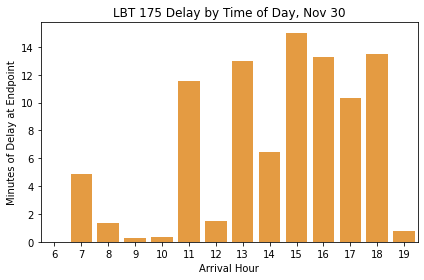

In [116]:
sns_plot = (sns.barplot(x=hour_grouped['Arrival Hour'], y=hour_grouped['Minutes of Delay at Endpoint'], ci=None, 
                       palette=shared_utils.altair_utils.FIVETHIRTYEIGHT_CATEGORY_COLORS[6:7])
            .set_title("LBT 175 Delay by Time of Day, Nov 30")
           )
chart3 = sns_plot.get_figure()
chart3.tight_layout()
chart3.savefig("./seaborn_chart.png")

In [ ]:
df = (test_many.route_coverage_summary()
 >> mutate(stops_covered = _.max_stop - _.min_stop)
 >> arrange(-_.stops_covered)
 >> filter(_.stops_covered > 1)
 >> distinct(_.shape_id, _keep_all=True)
)
df.head(5)

In [56]:
# test_many.map_stop_delays() ## broken/inf recursion (delay view check failing?)

In [57]:
# test_many.map_segment_speeds(how = 'low_speeds')

In [58]:
colorscale = branca.colormap.step.RdYlGn_10.scale(vmin=0, 
 vmax=30)
colorscale.caption = "Speed (miles per hour)"

In [59]:
# m = test_many._generate_segment_map(how = 'low_speeds', colorscale = colorscale)

In [60]:
# m

In [61]:
# test_delay = test_many.delay_view.copy()

### Sandbox

In [62]:
test_analysis.st_geo.head(3)

,calitp_itp_id,calitp_url_number,stop_id,stop_lat,stop_lon,stop_name,geometry,trip_id,stop_sequence,arrival_time,departure_time,stop_headsign,pickup_type,drop_off_type,continuous_pickup,continuous_drop_off,shape_dist_traveled,timepoint,calitp_extracted_at
0,170,0,3150,33.792724,-118.222183,VILLAGES AT CABRILLO,POINT (164664.672 -467611.924),9288591,29,07:00:00,07:00:00,None,1,0,None,None,7.127999999999999,1,2021-12-17
1,170,0,3150,33.792724,-118.222183,VILLAGES AT CABRILLO,POINT (164664.672 -467611.924),9288599,29,09:36:00,09:36:00,None,1,0,None,None,7.127999999999999,1,2021-12-17
2,170,0,3150,33.792724,-118.222183,VILLAGES AT CABRILLO,POINT (164664.672 -467611.924),9288601,29,10:20:00,10:20:00,None,1,0,None,None,7.127999999999999,1,2021-12-17


In [63]:
lbt_routelines.head(3)

,calitp_itp_id,calitp_url_number,shape_id,calitp_extracted_at,geometry
0,170,0,10069,2021-12-17,"LINESTRING (161216.993 -459406.837, 161188.049..."
1,170,0,10070,2021-12-17,"LINESTRING (165555.589 -461447.899, 165529.874..."
2,170,0,1010081,2021-12-17,"LINESTRING (178338.638 -463053.608, 178362.517..."


In [64]:
lbt_trips.head(3)

,calitp_itp_id,calitp_url_number,service_date,trip_key,trip_id,route_id,direction_id,shape_id,calitp_extracted_at,calitp_deleted_at
0,170,0,2021-11-30,7580361081022204604,9296678,41,0,410007,2021-09-16,2099-01-01
1,170,0,2021-11-30,4117806770041309601,9288195,191,1,1910292,2021-09-16,2099-01-01
2,170,0,2021-11-30,-2383767369974821641,9296601,46,0,460067,2021-09-16,2099-01-01


In [66]:
one_trip = lbt_trips >> filter(_.trip_key == 3082123411846948636) >> select(-_.calitp_deleted_at,
                                                                           -_.calitp_extracted_at)

trip_st_gdf = test_analysis.st_geo >> inner_join(_, one_trip,
                                           on = ['calitp_itp_id', 'calitp_url_number', 'trip_id'])

In [67]:
trip_st_gdf.head(3)

,calitp_itp_id,calitp_url_number,stop_id,stop_lat,stop_lon,stop_name,geometry,trip_id,stop_sequence,arrival_time,...,continuous_pickup,continuous_drop_off,shape_dist_traveled,timepoint,calitp_extracted_at,service_date,trip_key,route_id,direction_id,shape_id
0,170,0,3150,33.792724,-118.222183,VILLAGES AT CABRILLO,POINT (164664.672 -467611.924),9288593,29,07:36:00,...,None,None,7.127999999999999,1,2021-12-17,2021-11-30,3082123411846948636,175,0,1750012
1,170,0,0544,33.782963,-118.132392,LOS ALTOS & PCH NE,POINT (173001.551 -468534.279),9288593,6,07:08:00,...,None,None,1.295,1,2021-12-17,2021-11-30,3082123411846948636,175,0,1750012
2,170,0,1688,33.789962,-118.163612,PCH & JUNIPERO NW,POINT (170094.890 -467814.760),9288593,14,07:17:57,...,None,None,3.338,0,2021-12-17,2021-11-30,3082123411846948636,175,0,1750012


In [75]:
test1 = rt.ScheduleInterpolator(trip_st_gdf = trip_st_gdf, shape_gdf = lbt_routelines)

In [76]:
test1.time_at_position(7707.513766)

Timestamp('2021-11-30 07:25:00')

In [77]:
test2 = rt.ScheduleInterpolator(trip_st_gdf = trip_st_gdf, shape_gdf = lbt_routelines)

In [78]:
test2.time_at_position(7707.513766)

Timestamp('2021-11-30 07:25:00')

In [73]:
# test2.detailed_speed_map()

In [74]:
#TODO rewrite to not modify attributes!!

endpoint_delay_sum = (test_delay
 >> group_by(_.trip_id)
 >> filter(_.stop_sequence == _.stop_sequence.max())
 >> ungroup()
 >> mutate(total_delay = _.delay.sum())
)

NameError: name 'test_delay' is not defined

In [ ]:
starts = (test_delay
 >> group_by(_.trip_id)
 >> filter(_.stop_sequence == _.stop_sequence.min())
 >> ungroup()
 # >> mutate(total_delay = _.delay.sum())
 >> select(_.start_time == _.actual_time, _.trip_id, _.start_meters == _.shape_meters)
)

In [ ]:
speed_and_delay = endpoint_delay_sum >> inner_join(_, starts, on='trip_id')

speed_and_delay['seconds'] = speed_and_delay.apply(
    lambda x: (x.actual_time - x.start_time).seconds, axis=1)

speed_and_delay['trip_speed'] = (speed_and_delay.shape_meters - speed_and_delay.start_meters) / speed_and_delay.seconds

speed_and_delay['trip_speed_mph'] = speed_and_delay.trip_speed * MPH_PER_MPS

speed_and_delay['trip_speed_mph'].mean()

In [ ]:
speed_and_delay.head(3)

In [ ]:
((speed_and_delay.shape_meters - speed_and_delay.start_meters).sum()
/ speed_and_delay.seconds.sum()) * MPH_PER_MPS

In [ ]:
# speed_and_delay >> mutate(total_mean_mph = (
#     (_.shape_meters - _.start_meters).sum()
#     / _.seconds.sum()) * MPH_PER_MPS)

In [ ]:
(lbt_routelines.calitp_itp_id == 170).all()